# 4. Evaluacion modelos de clasificacion binaria con sobremuestreo aleatorio para la clase minoritaria
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:      |
| Escalado de datos         | No            |
| Ajuste de hiperparametros | Si            |
| Sobremuestreo             | Si            |
| Ajuste de pesos de clase  | No            |



### Cargar librerias

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier


Using TensorFlow backend.


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [4]:
# ruta para grabar medidas de desempeño
ruta4 = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4.xlsx"
writer = pd.ExcelWriter(ruta4, engine='openpyxl')

### Preparar datos agil

In [5]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2
data_train=train.iloc[:,np.r_[2:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[2:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

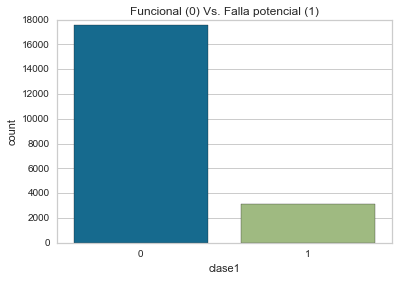

In [6]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [7]:
# sobremuestreo aleatorio para la base de entrenamiento
ros = RandomOverSampler(random_state=0)
data_traino, label_traino = ros.fit_resample(data_train, label_train)

# validar el conteo por clase

print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [8]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

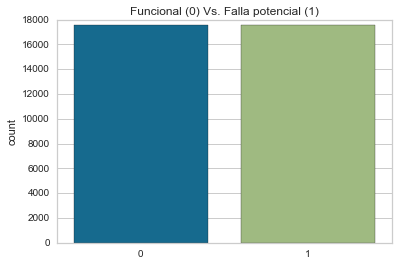

In [9]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [10]:
# convertir a formato Data frame
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [11]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 24)
total datos = 841488


# Modelos de clasificacion binaria 

## Modelo Random Forest 

In [37]:
modelo1=RandomForestClassifier(random_state=0, n_estimators=10)
modelo1.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [38]:
label_pred1 = modelo1.predict(data_test)

In [39]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo1.feature_importances_
fi

array([0.00983031, 0.00707437, 0.        , 0.        , 0.07066728,
       0.029565  , 0.10903923, 0.        , 0.        , 0.1522517 ,
       0.01313126, 0.04906032, 0.        , 0.04169869, 0.094952  ,
       0.01382081, 0.02845073, 0.17013527, 0.        , 0.11215686,
       0.        , 0.        , 0.07504346, 0.02312272])

#### Evaluacion del modelo



MATRIZ DE CONFUSION




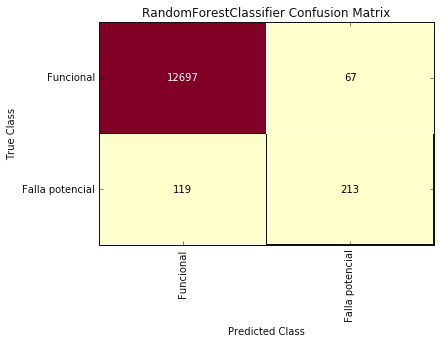



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9857971899816738
ROC AUC: 0.818158563429525
------------------------------------------------------------
Precisión por clase: [0.99071473 0.76071429]
Sensibilidad - Recall por clase: [0.99475086 0.64156627]
F1 por clase: [0.99272869 0.69607843]
------------------------------------------------------------
F1 Macro: 0.8444035628324824
F1 Micro: 0.9857971899816738
F1 Weighted: 0.9852082386350095
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.818158563429525
Sensibilidad - Recall Micro: 0.9857971899816738
Sensibilidad - Recall Weighted: 0.9857971899816738
------------------------------------------------------------
Precisión Macro: 0.8757145086499019
Precisión Micro: 0.9857971899816738
Precisión Weighted: 0.9848839322552456
------------------------------------------------------------
Verdaderos positivos - True Positives: 213
Verdaderos negativos - True Negatives: 12697
Falsos positivos

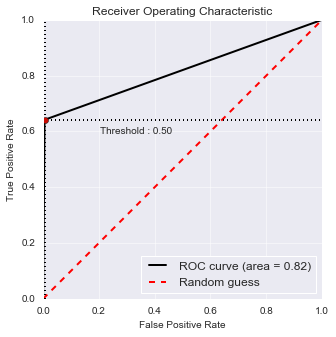

In [40]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

In [41]:
# grabar las medidas de desempeño
report1 = classification_report(label_test, label_pred1, output_dict=True)
df = pd.DataFrame(report1).transpose()
df.to_excel(writer, sheet_name='Random Forest')
writer.save()

### Modelo Random Forest con Grid Search CV

In [42]:
model = RandomForestClassifier(random_state=0)
parameters= {'n_estimators': [10, 50, 100, 200, 300, 400],
             'max_features': ['log2', 'sqrt', 'auto'],
             'criterion': ['entropy', 'gini'],
             'max_depth': [2, 4, 6, 8, 10]                 
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=2, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)


Fitting 2 folds for each of 180 candidates, totalling 360 fits
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=200 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=200, total=   1.2s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=200 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=200, total=   1.2s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, 

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.7min finished


Wall time: 11min 50s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'c

In [43]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
0.969653756203297
166


In [44]:
modelo1a= grid.best_estimator_
modelo1a.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [45]:
label_pred1a = modelo1a.predict(data_test)

In [46]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo1a.feature_importances_
fi

array([5.08650383e-03, 3.67813040e-03, 0.00000000e+00, 0.00000000e+00,
       4.92751367e-02, 3.58071012e-02, 1.12862219e-01, 0.00000000e+00,
       1.62224015e-04, 8.94519074e-02, 1.67678843e-02, 4.04833885e-02,
       0.00000000e+00, 1.73727763e-01, 1.31834317e-01, 1.56892066e-02,
       3.57910236e-02, 8.48201515e-02, 0.00000000e+00, 4.33032997e-02,
       0.00000000e+00, 0.00000000e+00, 6.59574874e-02, 9.53022561e-02])



MATRIZ DE CONFUSION




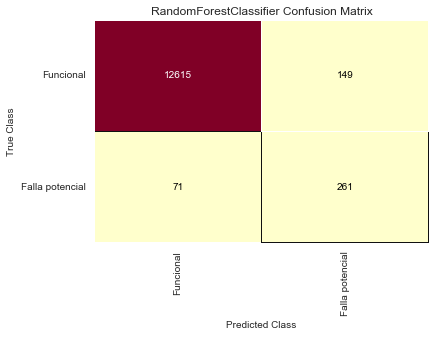



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9832009773976786
ROC AUC: 0.8872355608582874
------------------------------------------------------------
Precisión por clase: [0.99440328 0.63658537]
Sensibilidad - Recall por clase: [0.98832654 0.78614458]
F1 por clase: [0.9913556  0.70350404]
------------------------------------------------------------
F1 Macro: 0.847429821170415
F1 Micro: 0.9832009773976786
F1 Weighted: 0.9840582017934797
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8872355608582874
Sensibilidad - Recall Micro: 0.9832009773976786
Sensibilidad - Recall Weighted: 0.9832009773976786
------------------------------------------------------------
Precisión Macro: 0.8154943225295409
Precisión Micro: 0.9832009773976786
Precisión Weighted: 0.9853321470098838
------------------------------------------------------------
Verdaderos positivos - True Positives: 261
Verdaderos negativos - True Negatives: 12615
Falsos positivo

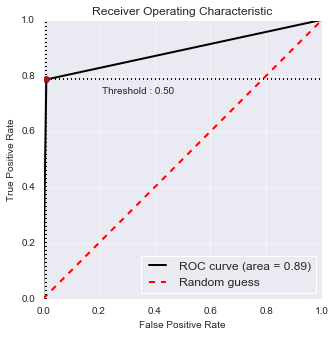

In [47]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1a, label_pred1a)

In [48]:
report1a = classification_report(label_test, label_pred1a, output_dict=True)
df1a = pd.DataFrame(report1a).transpose()
df1a.to_excel(writer, sheet_name='Random Forest Grid')
writer.save()

## Clasificador Gausiano Naive Bayes

In [49]:
modelo2 = GaussianNB()
modelo2.fit(data_train, label_train);
label_pred2 = modelo2.predict(data_test)



MATRIZ DE CONFUSION




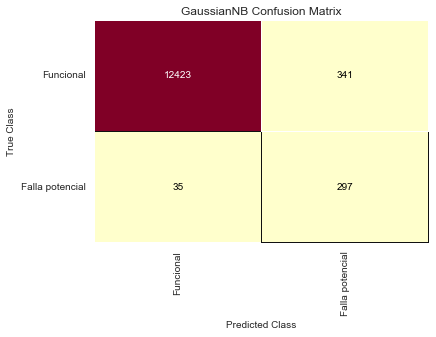



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9712889431887599
ROC AUC: 0.9339312750846696
------------------------------------------------------------
Precisión por clase: [0.99719056 0.46551724]
Sensibilidad - Recall por clase: [0.97328424 0.89457831]
F1 por clase: [0.98509238 0.61237113]
------------------------------------------------------------
F1 Macro: 0.7987317568445809
F1 Micro: 0.9712889431887599
F1 Weighted: 0.9756434293359906
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9339312750846696
Sensibilidad - Recall Micro: 0.9712889431887599
Sensibilidad - Recall Weighted: 0.9712889431887599
------------------------------------------------------------
Precisión Macro: 0.7313539008309299
Precisión Micro: 0.9712889431887599
Precisión Weighted: 0.9837119758387594
------------------------------------------------------------
Verdaderos positivos - True Positives: 297
Verdaderos negativos - True Negatives: 12423
Falsos positiv

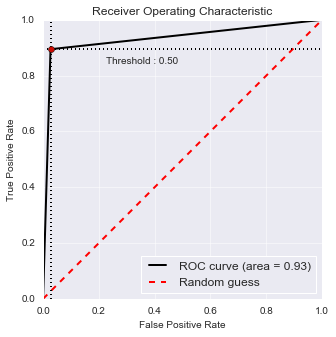

In [50]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2, label_pred2)

In [51]:
report2 = classification_report(label_test, label_pred2, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2.to_excel(writer, sheet_name='Naive Bayes')
writer.save()

## Clasificacion con Support Vector Machine

In [52]:
modelo3 = SVC(kernel='rbf', random_state=0)
modelo3.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [53]:
label_pred3 = modelo3.predict(data_test)



MATRIZ DE CONFUSION




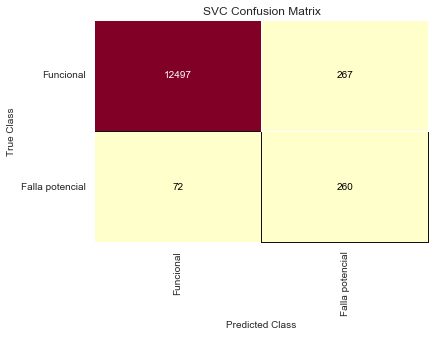



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9741142333536957
ROC AUC: 0.8811071613310025
------------------------------------------------------------
Precisión por clase: [0.99427162 0.49335863]
Sensibilidad - Recall por clase: [0.97908179 0.78313253]
F1 por clase: [0.98661824 0.60535506]
------------------------------------------------------------
F1 Macro: 0.7959866545024235
F1 Micro: 0.9741142333536957
F1 Weighted: 0.9769527458874867
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8811071613310024
Sensibilidad - Recall Micro: 0.9741142333536957
Sensibilidad - Recall Weighted: 0.9741142333536957
------------------------------------------------------------
Precisión Macro: 0.7438151272150405
Precisión Micro: 0.9741142333536957
Precisión Weighted: 0.9815728491479223
------------------------------------------------------------
Verdaderos positivos - True Positives: 260
Verdaderos negativos - True Negatives: 12497
Falsos positiv

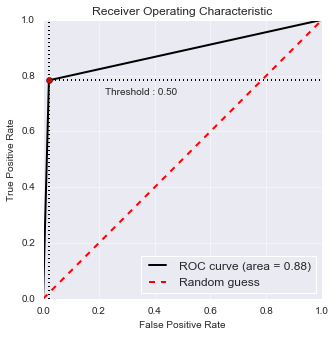

In [54]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo3, label_pred3)

In [55]:
report3 = classification_report(label_test, label_pred3, output_dict=True)
df3 = pd.DataFrame(report3).transpose()
df3.to_excel(writer, sheet_name='SVC')
writer.save()

## Clasificacion Linear SVC

In [56]:
modelo4 = LinearSVC(random_state=0, max_iter=10000)
modelo4.fit(data_train, label_train);
label_pred4 = modelo4.predict(data_test)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




MATRIZ DE CONFUSION




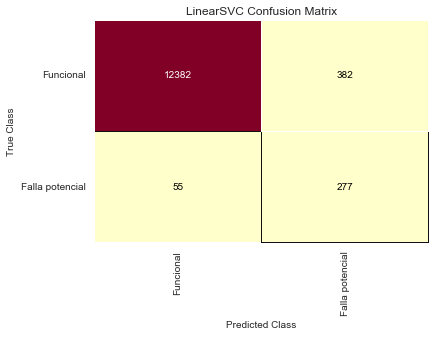



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9666310323762981
ROC AUC: 0.902204713558087
------------------------------------------------------------
Precisión por clase: [0.99557771 0.42033384]
Sensibilidad - Recall por clase: [0.97007208 0.83433735]
F1 por clase: [0.98265942 0.55903128]
------------------------------------------------------------
F1 Macro: 0.7708453499054284
F1 Micro: 0.9666310323762981
F1 Weighted: 0.971919914505003
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.902204713558087
Sensibilidad - Recall Micro: 0.9666310323762981
Sensibilidad - Recall Weighted: 0.9666310323762981
------------------------------------------------------------
Precisión Macro: 0.7079557754085142
Precisión Micro: 0.9666310323762981
Precisión Weighted: 0.9809945591259102
------------------------------------------------------------
Verdaderos positivos - True Positives: 277
Verdaderos negativos - True Negatives: 12382
Falsos positivos 

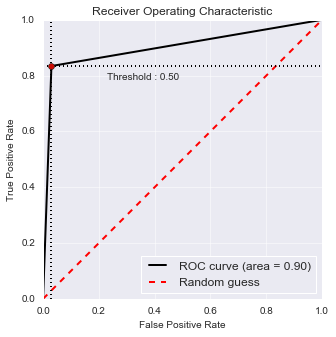

In [57]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo4, label_pred4)

In [58]:
report4 = classification_report(label_test, label_pred4, output_dict=True)
df4 = pd.DataFrame(report4).transpose()
df4.to_excel(writer, sheet_name='linearSVC')
writer.save()

## k-NN KNeighborsClassifier con grid search CV

In [59]:
model = KNeighborsClassifier()
parameters= {'n_neighbors': np.arange(1, 100, 2)            
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=5, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=2)

In [60]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'n_neighbors': 1}
0.9764132108835777
0


In [61]:
modelo5= grid.best_estimator_
modelo5.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [62]:
label_pred5 = modelo5.predict(data_test)



MATRIZ DE CONFUSION




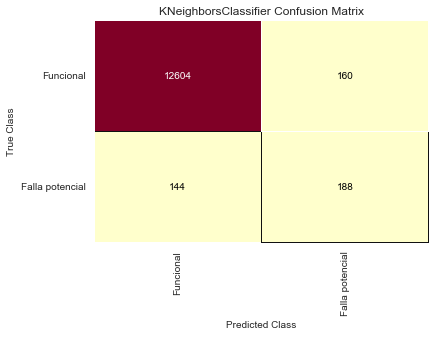



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9767868051313379
ROC AUC: 0.7768649024175674
------------------------------------------------------------
Precisión por clase: [0.98870411 0.54022989]
Sensibilidad - Recall por clase: [0.98746474 0.56626506]
F1 por clase: [0.98808404 0.55294118]
------------------------------------------------------------
F1 Macro: 0.7705126076771255
F1 Micro: 0.9767868051313379
F1 Weighted: 0.9770526223960986
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7768649024175676
Sensibilidad - Recall Micro: 0.9767868051313379
Sensibilidad - Recall Weighted: 0.9767868051313379
------------------------------------------------------------
Precisión Macro: 0.7644669977530846
Precisión Micro: 0.9767868051313379
Precisión Weighted: 0.9773347272148946
------------------------------------------------------------
Verdaderos positivos - True Positives: 188
Verdaderos negativos - True Negatives: 12604
Falsos positiv

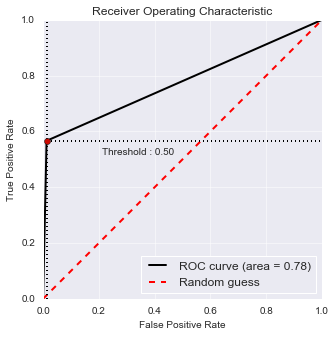

In [63]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo5, label_pred5)

In [64]:
report5 = classification_report(label_test, label_pred5, output_dict=True)
df5 = pd.DataFrame(report5).transpose()
df5.to_excel(writer, sheet_name='KNN')
writer.save()

## Clasificacion con arbol de decision con Grid Search CV

In [65]:
model = tree.DecisionTreeClassifier()
depths = np.arange(1,20)
parameters= {'max_depth' : depths,
             'min_samples_leaf' : [1, 5, 10, 20, 50, 100],
             'criterion': ['entropy', 'gini'],
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=5, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)

Fitting 5 folds for each of 228 candidates, totalling 1140 fits
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............

[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:  2.5min finished


Wall time: 2min 31s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8, 

In [66]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 1}
0.9802350122639895
108


In [67]:
modelo6= grid.best_estimator_
modelo6.fit(data_train, label_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=19,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [68]:
label_pred6 = modelo6.predict(data_test)



MATRIZ DE CONFUSION




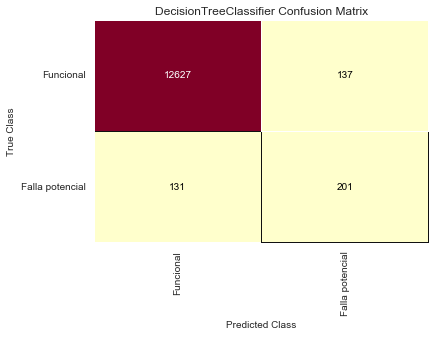



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9795357361026268
ROC AUC: 0.7973441871528735
------------------------------------------------------------
Precisión por clase: [0.98973193 0.59467456]
Sensibilidad - Recall por clase: [0.98926669 0.60542169]
F1 por clase: [0.98949926 0.6       ]
------------------------------------------------------------
F1 Macro: 0.7947496277721182
F1 Micro: 0.9795357361026268
F1 Weighted: 0.9796249616498652
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7973441871528735
Sensibilidad - Recall Micro: 0.9795357361026268
Sensibilidad - Recall Weighted: 0.9795357361026268
------------------------------------------------------------
Precisión Macro: 0.7922032445589309
Precisión Micro: 0.9795357361026268
Precisión Weighted: 0.9797167336789976
------------------------------------------------------------
Verdaderos positivos - True Positives: 201
Verdaderos negativos - True Negatives: 12627
Falsos positiv

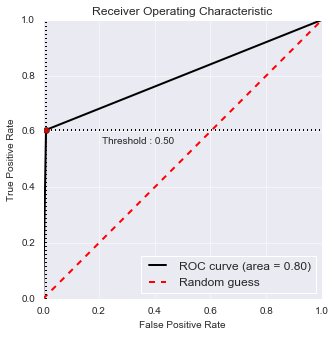

In [69]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo6, label_pred6)

In [70]:
report6 = classification_report(label_test, label_pred6, output_dict=True)
df6 = pd.DataFrame(report6).transpose()
df6.to_excel(writer, sheet_name='Tree')
writer.save()

## Clasificacion por regresion logistica con Grid Search CV

In [71]:
model = LogisticRegression(solver='liblinear')
c = np.arange(1,20)
parameters= {'C' : c,}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=5, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................................. C=1, total=   0.4s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................................. C=1, total=   0.6s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.4s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.5s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.5s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=   0.5s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=   0.5s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=   0.6s
[CV] C=2 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:   58.4s finished


Wall time: 59.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=2)

In [72]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'C': 8}
0.9427015001996464
7


In [73]:
modelo7= grid.best_estimator_
modelo7.fit(data_train, label_train)

LogisticRegression(C=8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
label_pred7 = modelo7.predict(data_test)



MATRIZ DE CONFUSION




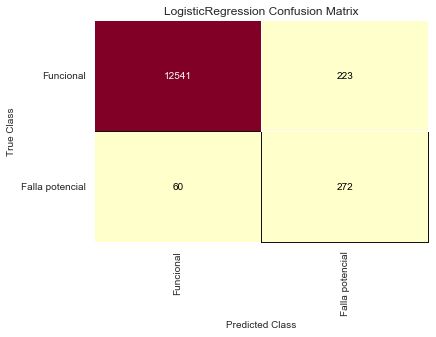



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.978390348197923
ROC AUC: 0.9009030481059305
------------------------------------------------------------
Precisión por clase: [0.99523847 0.54949495]
Sensibilidad - Recall por clase: [0.98252899 0.81927711]
F1 por clase: [0.98884289 0.65779927]
------------------------------------------------------------
F1 Macro: 0.8233210841186632
F1 Micro: 0.978390348197923
F1 Weighted: 0.9804505234399901
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9009030481059305
Sensibilidad - Recall Micro: 0.978390348197923
Sensibilidad - Recall Weighted: 0.978390348197923
------------------------------------------------------------
Precisión Macro: 0.7723667113160011
Precisión Micro: 0.978390348197923
Precisión Weighted: 0.9839383166122223
------------------------------------------------------------
Verdaderos positivos - True Positives: 272
Verdaderos negativos - True Negatives: 12541
Falsos positivos - 

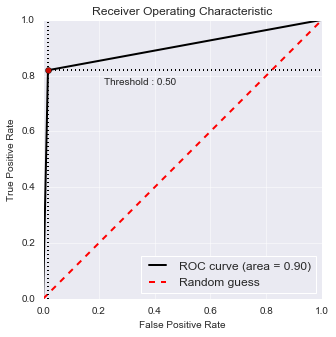

In [75]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo7, label_pred7)

In [76]:
report7 = classification_report(label_test, label_pred7, output_dict=True)
df7 = pd.DataFrame(report7).transpose()
df7.to_excel(writer, sheet_name='LogisticR')
writer.save()

## Clasificacion con red neuronal MLP

In [77]:
modelo8= MLPClassifier(random_state=0)
modelo8.fit(data_train, label_train);
label_pred8 = modelo8.predict(data_test)




MATRIZ DE CONFUSION




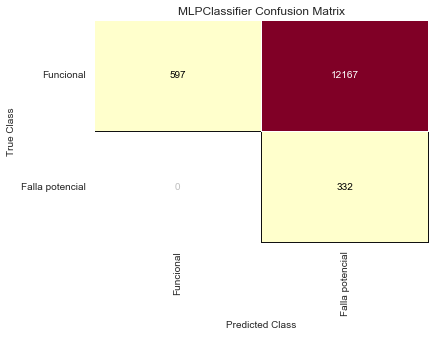



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.07093769089798412
ROC AUC: 0.5233860858664996
------------------------------------------------------------
Precisión por clase: [1.         0.02656212]
Sensibilidad - Recall por clase: [0.04677217 1.        ]
F1 por clase: [0.08936457 0.05174967]
------------------------------------------------------------
F1 Macro: 0.07055711864563285
F1 Micro: 0.07093769089798412
F1 Weighted: 0.08841098370688169
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.5233860858664995
Sensibilidad - Recall Micro: 0.07093769089798412
Sensibilidad - Recall Weighted: 0.07093769089798412
------------------------------------------------------------
Precisión Macro: 0.5132810624849988
Precisión Micro: 0.07093769089798412
Precisión Weighted: 0.9753221308407177
------------------------------------------------------------
Verdaderos positivos - True Positives: 332
Verdaderos negativos - True Negatives: 597
Falsos po

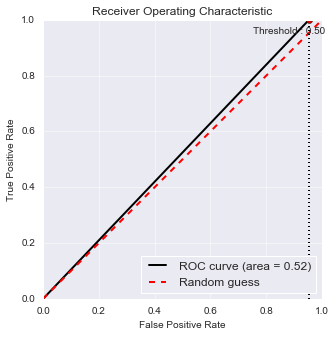

In [78]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo8, label_pred8)

In [79]:
report8 = classification_report(label_test, label_pred8, output_dict=True)
df8 = pd.DataFrame(report8).transpose()
df8.to_excel(writer, sheet_name='MLP')
writer.save()

## Red neronal MLP con grid search

In [80]:
model = MLPClassifier(random_state=0)

parameters= {'learning_rate':["constant", "invscaling", "adaptive"],
             'hidden_layer_sizes':[(8),(2,4),(1,8,1),(1,1,1),(2,8,2),(4,16,4), (1,2,1)],
             'activation': ["identity","logistic", "relu", "tanh"],
             'solver': ["lbfgs", "sgd", "adam"]
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=2, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)


Fitting 2 folds for each of 252 candidates, totalling 504 fits
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd, total=   3.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd, total=   3.2s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd, total=   3.3s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd, total=   3.3s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam, total=   1.7s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd, total=   3.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd, total=   3.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam, total=   1.7s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd, total=   4.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd, total=   4.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd, total=   3.9s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd, total=   3.8s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd, total=   3.9s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd, total=   3.8s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam, total=   5.5s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam, total=   5.4s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd, total=   4.5s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd, total=   4.5s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam, total=   5.3s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam, total=   5.6s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd, total=   4.6s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd, total=   4.5s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam, total=   5.5s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam, total=   5.6s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd, total=   4.9s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd, total=   4.8s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscal

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=sgd, total=   4.8s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=sgd, total=   4.9s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adapt

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=sgd, total=   4.9s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=sgd, total=   5.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, 

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=sgd, total=   5.2s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=sgd, total=   5.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_ra

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=sgd, total=   5.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=sgd, total=   5.2s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=sgd, total=   5.2s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=sgd, total=   5.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, 

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=sgd, total=   4.5s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam, total=   5.5s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam, total=   5.4s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd, total=   4.5s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam, total=   5.3s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam, total=   5.4s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam, total=   5.4s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam, total=   5.5s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=cons

[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:  8.3min finished


Wall time: 8min 26s


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['identity', 'logistic', 'relu', 'tanh'],
                         'hidden_layer_sizes': [8, (2, 4), (1, 8, 1), (1, 1, 1),
                                                (2, 8, 2), (4, 16, 4),
                                                (

In [81]:
modelo9= grid.best_estimator_
modelo9.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=8, learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [82]:
label_pred9 = modelo9.predict(data_test)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)




MATRIZ DE CONFUSION




C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


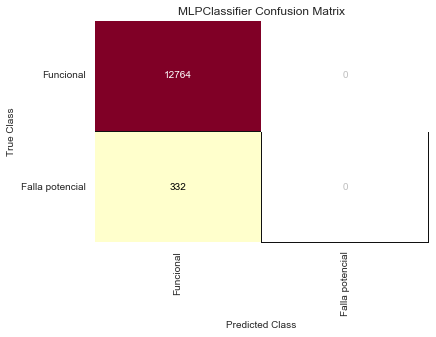

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9746487477092242
ROC AUC: 0.5
------------------------------------------------------------
Precisión por clase: [0.97464875 0.        ]
Sensibilidad - Recall por clase: [1. 0.]
F1 por clase: [0.98716164 0.        ]
------------------------------------------------------------
F1 Macro: 0.49358081979891727
F1 Micro: 0.9746487477092242
F1 Weighted: 0.9621358558206139
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.5
Sensibilidad - Recall Micro: 0.9746487477092242
Sensibilidad - Recall Weighted: 0.9746487477092242

C:\Users\alexh\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



------------------------------------------------------------
Precisión Macro: 0.4873243738546121
Precisión Micro: 0.9746487477092242
Precisión Weighted: 0.949940181411159
------------------------------------------------------------
Verdaderos positivos - True Positives: 0
Verdaderos negativos - True Negatives: 12764
Falsos positivos - False Positives: 0
Falsos negativos - False Negatives: 332
------------------------------------------------------------
Error de clasificacion: 0.025
Especificidad - Specificity: 0.975
Tasa de falsos positivos FPR: 0.025
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     12764
           1       0.00      0.00      0.00       332

    accuracy                           0.97     13096
   macro avg       0.49      0.50      0.49     13096
weighted avg       0.95      0.97      0.96     13096



CURVA ROC


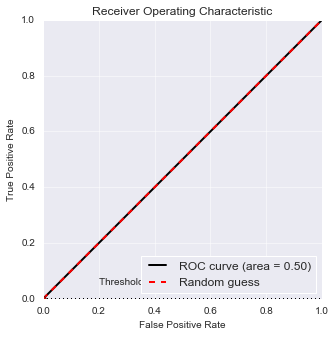

In [83]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, modelo9, label_pred9)

In [84]:
report9 = classification_report(label_test, label_pred9, output_dict=True)
df9 = pd.DataFrame(report9).transpose()
df9.to_excel(writer, sheet_name='MLP 8')
writer.save()

In [86]:
# prueba con 4 capas ocultas
param_grid = {'hidden_layer_sizes':[(1,2,2,1),(2,4,4,2), (4,4,4,4), (4,8,8,4), (4,16,16,4), (8,32,32,8)]}
grid = GridSearchCV(model, param_grid, cv=5, verbose=2, scoring='accuracy')

%time grid.fit(data_train, label_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] hidden_layer_sizes=(1, 2, 2, 1) .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. hidden_layer_sizes=(1, 2, 2, 1), total=   1.4s
[CV] hidden_layer_sizes=(1, 2, 2, 1) .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] .................. hidden_layer_sizes=(1, 2, 2, 1), total=   1.3s
[CV] hidden_layer_sizes=(1, 2, 2, 1) .................................
[CV] .................. hidden_layer_sizes=(1, 2, 2, 1), total=   1.3s
[CV] hidden_layer_sizes=(1, 2, 2, 1) .................................
[CV] .................. hidden_layer_sizes=(1, 2, 2, 1), total=   1.4s
[CV] hidden_layer_sizes=(1, 2, 2, 1) .................................
[CV] .................. hidden_layer_sizes=(1, 2, 2, 1), total=   1.2s
[CV] hidden_layer_sizes=(2, 4, 4, 2) .................................
[CV] .................. hidden_layer_sizes=(2, 4, 4, 2), total=   1.3s
[CV] hidden_layer_sizes=(2, 4, 4, 2) .................................
[CV] .................. hidden_layer_sizes=(2, 4, 4, 2), total=   1.4s
[CV] hidden_layer_sizes=(2, 4, 4, 2) .................................
[CV] .................. hidden_layer_sizes=(2, 4, 4, 2), total=   1.3s
[CV] hidden_layer_sizes=(2, 4, 4, 2) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   32.7s finished


Wall time: 34.2 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=0, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'hidden_layer_sizes': [(1, 2, 2, 1), (2, 4, 

In [87]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'hidden_layer_sizes': (1, 2, 2, 1)}
0.5
0


In [88]:
modelo10 = grid.best_estimator_
modelo10.fit(data_train, label_train)
label_pred10 = modelo10.predict(data_test)



MATRIZ DE CONFUSION




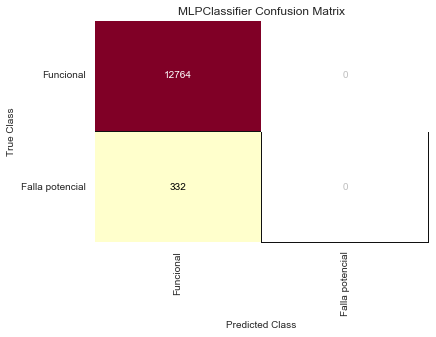



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9746487477092242
ROC AUC: 0.5
------------------------------------------------------------
Precisión por clase: [0.97464875 0.        ]
Sensibilidad - Recall por clase: [1. 0.]
F1 por clase: [0.98716164 0.        ]
------------------------------------------------------------
F1 Macro: 0.49358081979891727
F1 Micro: 0.9746487477092242
F1 Weighted: 0.9621358558206139
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.5
Sensibilidad - Recall Micro: 0.9746487477092242
Sensibilidad - Recall Weighted: 0.9746487477092242
------------------------------------------------------------
Precisión Macro: 0.4873243738546121
Precisión Micro: 0.9746487477092242
Precisión Weighted: 0.949940181411159
------------------------------------------------------------
Verdaderos positivos - True Positives: 0
Verdaderos negativos - True Negatives: 12764
Falsos positivos - False Positives: 0
Falsos negativos - False

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alexh\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


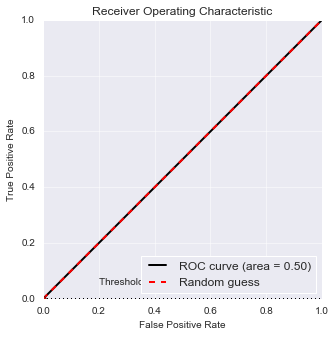

In [89]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, modelo10, label_pred10)

In [90]:
report10 = classification_report(label_test, label_pred10, output_dict=True)
df10 = pd.DataFrame(report10).transpose()
df10.to_excel(writer, sheet_name='MLP1221')
writer.save()

## Bagging Classifier

In [12]:
modelo8= BaggingClassifier(random_state=0)
modelo8.fit(data_train, label_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=0, verbose=0,
                  warm_start=False)



MATRIZ DE CONFUSION




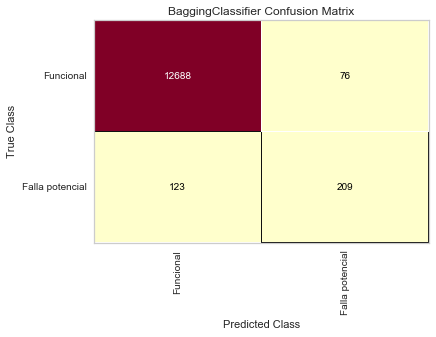



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9848045204642639
ROC AUC: 0.8117819129856938
------------------------------------------------------------
Precisión por clase: [0.99039888 0.73333333]
Sensibilidad - Recall por clase: [0.99404575 0.62951807]
F1 por clase: [0.99221896 0.67747164]
------------------------------------------------------------
F1 Macro: 0.8348453003924328
F1 Micro: 0.9848045204642639
F1 Weighted: 0.9842397249403138
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8117819129856939
Sensibilidad - Recall Micro: 0.9848045204642639
Sensibilidad - Recall Weighted: 0.9848045204642639
------------------------------------------------------------
Precisión Macro: 0.8618661046496501
Precisión Micro: 0.9848045204642639
Precisión Weighted: 0.9838819425394217
------------------------------------------------------------
Verdaderos positivos - True Positives: 209
Verdaderos negativos - True Negatives: 12688
Falsos positiv

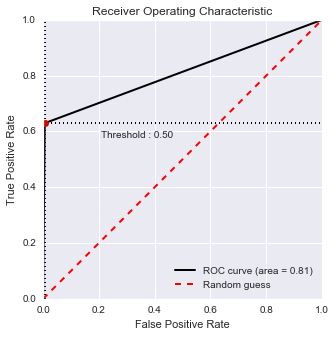

In [13]:
label_pred8 = modelo8.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo8, label_pred8)

## Extra Trees Classifier

In [14]:
modelo9=ExtraTreesClassifier(n_estimators=100, random_state=0)
modelo9.fit(data_train, label_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)



MATRIZ DE CONFUSION




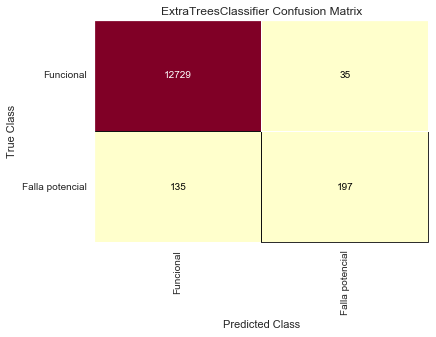



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9870189370800244
ROC AUC: 0.7953157034279392
------------------------------------------------------------
Precisión por clase: [0.9895056  0.84913793]
Sensibilidad - Recall por clase: [0.99725791 0.59337349]
F1 por clase: [0.99336663 0.69858156]
------------------------------------------------------------
F1 Macro: 0.8459740952659269
F1 Micro: 0.9870189370800244
F1 Weighted: 0.9858934595679424
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7953157034279392
Sensibilidad - Recall Micro: 0.9870189370800244
Sensibilidad - Recall Weighted: 0.9870189370800244
------------------------------------------------------------
Precisión Macro: 0.919321764024704
Precisión Micro: 0.9870189370800244
Precisión Weighted: 0.9859471009011878
------------------------------------------------------------
Verdaderos positivos - True Positives: 197
Verdaderos negativos - True Negatives: 12729
Falsos positivo

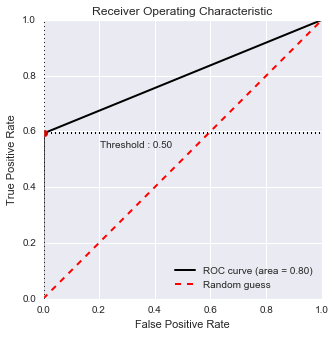

In [15]:
label_pred9 = modelo9.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo9, label_pred9)

## Gradient Boosting Classifier

In [16]:
modelo10=GradientBoostingClassifier(n_estimators=100)
modelo10.fit(data_train, label_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)



MATRIZ DE CONFUSION




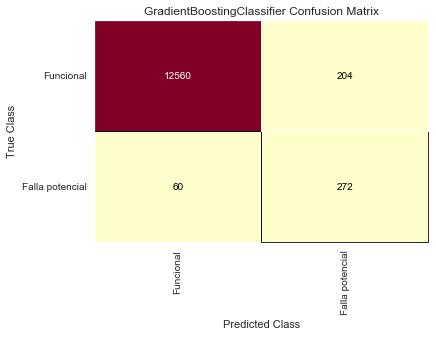



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9798411728772144
ROC AUC: 0.9016473288956515
------------------------------------------------------------
Precisión por clase: [0.99524564 0.57142857]
Sensibilidad - Recall por clase: [0.98401755 0.81927711]
F1 por clase: [0.98959975 0.67326733]
------------------------------------------------------------
F1 Macro: 0.8314335373026744
F1 Micro: 0.9798411728772144
F1 Weighted: 0.9815803248566034
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9016473288956515
Sensibilidad - Recall Micro: 0.9798411728772144
Sensibilidad - Recall Weighted: 0.9798411728772144
------------------------------------------------------------
Precisión Macro: 0.7833371066334616
Precisión Micro: 0.9798411728772144
Precisión Weighted: 0.984501348361256
------------------------------------------------------------
Verdaderos positivos - True Positives: 272
Verdaderos negativos - True Negatives: 12560
Falsos positivo

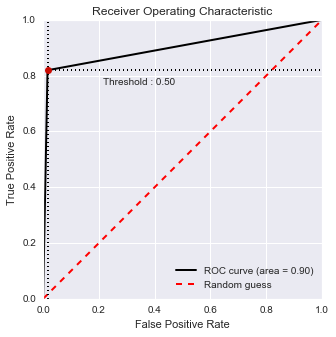

In [17]:
label_pred10 = modelo10.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo10, label_pred10)